# Stroke Prediction Using Clinical Data And CT

## Import Libraries

In [2]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
import random
import tensorflow as tf
from keras import backend as K

import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

import keras
import tensorflow
from tensorflow.python.keras import layers
from tensorflow.python.keras import models
from tensorflow.keras.callbacks import ModelCheckpoint
from scipy import ndimage
from keras.applications import MobileNetV2
import nibabel as nib
from imblearn.metrics import specificity_score
from sklearn.preprocessing import label_binarize

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Conv2D, Flatten, Input

from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Flatten, Dense, BatchNormalization, concatenate

from tensorflow.keras.models import Model

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

np.random.seed(1)
keras.utils.set_random_seed(1)

drive_path = ''

tensorflow.random.set_seed(1)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(style='whitegrid')

## Load Dataset

### Clinical + Lab Data

In [3]:
# load clinical data from csv file
dataset = pd.read_csv('dataset_l2norm.csv', delimiter=',', decimal='.')
dataset = dataset.drop(['ct_axial', 'ct_coronal', 'ct_sagittal'], axis=1)
dataset.drop(columns=['Unnamed: 0'], inplace=True)
dataset

patient_id    awitan      usia  tensi_atas  tensi_bawah        pt  \
0             1  0.084363  0.082348    0.081907     0.093346  0.078607   
1             2  0.065616  0.104680    0.081907     0.065343  0.099213   
2             3  0.047806  0.058621    0.069894     0.085879  0.083186   
3             4  0.056242  0.066995    0.082126     0.084572  0.080134   
4             5  0.126544  0.087931    0.120131     0.093346  0.082423   
..          ...       ...       ...         ...          ...       ...   
140         144  0.056242  0.071183    0.065526     0.065343  0.090818   
141         145  0.084363  0.083744    0.076447     0.065343  0.086239   
142         146  0.007030  0.044664    0.076884     0.083452  0.090818   
143         147  0.051555  0.073974    0.120131     0.102681  0.072502   
144         148  0.028121  0.079138    0.070495     0.071783  0.084713   

         pt_c      aptt    aptt_c  fibrinogen       gds nihss_delta_3_cat  \
0    0.086936  0.054387  0.079857    0.108844  0.118202          memburuk   
1    0.087685  0.091623  0.078625    0.090270  0.069889          memburuk   
2    0.084687  0.054387  0.075421    0.051067  0.061915          memburuk   
3    0.087685  0.057998  0.088237    0.094169  0.080067           membaik   
4    0.086936  0.074472  0.082815    0.084103  0.071296        signifikan   
..        ...       ...       ...         ...       ...               ...   
140  0.081690  0.078308  0.079857    0.079684  0.061915          memburuk   
141  0.077193  0.091397  0.081090    0.075076  0.066137        signifikan   
142  0.085437  0.057772  0.078132    0.084599  0.080443           membaik   
143  0.083938  0.084627  0.087005    0.078219  0.216703          memburuk   
144  0.078692  0.088238  0.080350    0.068081  0.062947        signifikan   

    nihss_delta_2_cat  
0    tidak signifikan  
1    tidak signifikan  
2    tidak signifikan  
3    tidak signifikan  
4          signifikan  
..                ...  
140  tidak signifikan  
141        signifikan  
142  tidak signifikan  
143  tidak signifikan  
144        signifikan  

[145 rows x 13 columns]

In [4]:
x_clin = dataset[['awitan', 'usia', 'tensi_atas', 'tensi_bawah']]
x_clin_val = x_clin.iloc[33:57]
x_clin = pd.concat([x_clin.iloc[0:33], x_clin.iloc[57:]])

In [5]:
x_clin_lab = dataset[['awitan', 'usia', 'tensi_atas', 'tensi_bawah', 'pt', 'aptt', 'fibrinogen', 'gds']]
x_clin_lab_val = x_clin_lab.iloc[33:57]
x_clin_lab = pd.concat([x_clin_lab.iloc[0:33], x_clin_lab.iloc[57:]])

### CT Data

In [6]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

def plot_slices(num_rows, num_columns, width, height, data):
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")


In [7]:
@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [8]:
ct_data_axial = []
ct_data_axial_id = []

dir_output = drive_path + 'Dataset/brain_mask/'
for filename in os.listdir(dir_output):
    dir_file = dir_output + filename
    id = filename.split('_')[1]

    if '.DS_Store' in filename:
        continue

    img_data = process_scan(dir_file)

    # You may need additional preprocessing steps, e.g., resizing, normalization, etc.
    ct_data_axial.append(img_data)

    # ct_data_axial.append(image)
    ct_data_axial_id.append(id)

In [9]:
x = np.array(ct_data_axial)
x_val = x[33:57]
x = np.concatenate((x[0:33], x[57:]))

Dimension of the CT scan is: (128, 128, 64)


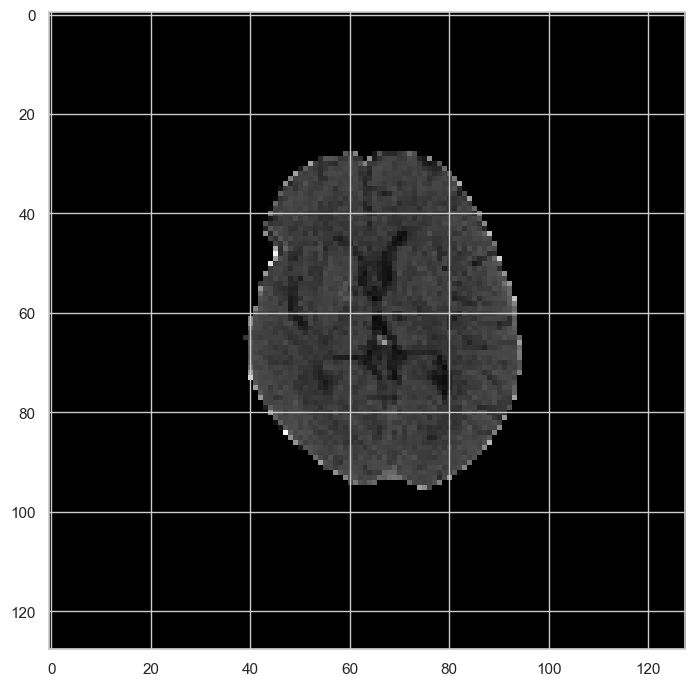

In [10]:
images = x[0]
print("Dimension of the CT scan is:", images.shape)
plt.imshow(np.squeeze(images[:, :, 30]), cmap="gray")

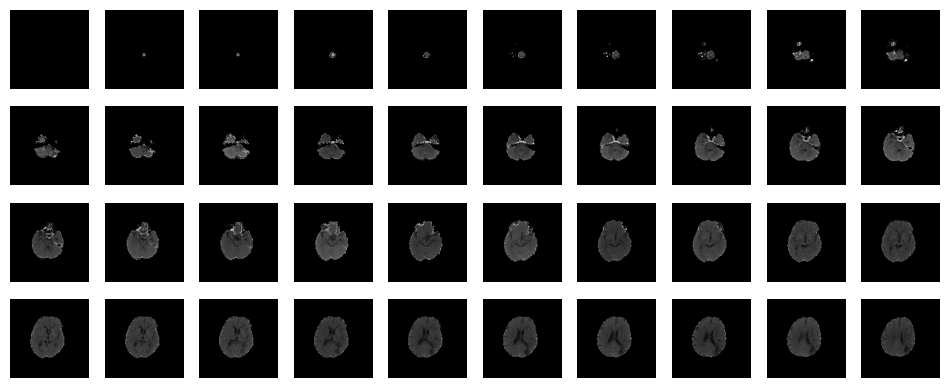

In [11]:
plot_slices(4, 10, 128, 128, images[:, :, :40])

In [12]:
y_delta_3 = []
y_delta_2 = []
for inc, id in enumerate(ct_data_axial_id):
    try:
        y_delta_3.append(dataset[dataset.patient_id == int(id)]['nihss_delta_3_cat'].values.tolist()[0])
        y_delta_2.append(dataset[dataset.patient_id == int(id)]['nihss_delta_2_cat'].values.tolist()[0])
    except:
        inc = inc + 1
        pass

y_delta_3 = np.array(y_delta_3)
y_delta_2 = np.array(y_delta_2)

In [12]:
y_delta_3_val = np.array(pd.get_dummies(y_delta_3[33:57]))
y_delta_3 = np.concatenate((y_delta_3[0:33], y_delta_3[57:]))

In [13]:
y_delta_2_val = np.array(pd.get_dummies(y_delta_2[33:57]))
y_delta_2 = np.concatenate((y_delta_2[0:33], y_delta_2[57:]))

## Machine Learning

In [14]:
categorize_3 = ['membaik', 'memburuk', 'signifikan']
categorize_2 = ['signifikan', 'tidak signifikan']

In [15]:
def define_model(num_of_label, path, scenario='ct'):
    checkpoint_filepath = drive_path + 'Models/bacchi/dataval/' + path
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_f1_m',
        mode='max',
        save_best_only=True)

    # clear_model()

    img_input = Input((128, 128, 64, 1))
    clinical_input = Input((4,))
    clinical_lab_input = Input((8,))

    x1 = Conv3D(32, kernel_size=3, activation='relu')(img_input)
    x1 = MaxPooling3D(pool_size=3)(x1)

    x1 = Conv3D(64, kernel_size=3, activation='relu')(x1)
    x1 = MaxPooling3D(pool_size=3)(x1)

    # Flattening layer
    x1 = Flatten()(x1)

    if scenario != 'ct':
        if scenario == 'ct_clinic':
            x2 = Flatten()(clinical_input)
        else:
            x2 = Flatten()(clinical_lab_input)
        x2 = Dense(6, activation='relu')(x2)
        x2 = Dense(4, activation='relu')(x2)
        x2 = Dense(4, activation='relu')(x2)

        x1 = concatenate([x1, x2])

    # Fully connected layers
    x1 = Dense(32, activation='relu')(x1)
    x1 = BatchNormalization()(x1)

    x1 = Dense(2, activation='relu')(x1)
    x1 = Dense(6, activation='relu')(x1)

    output = Dense(num_of_label, activation='softmax')(x1)

    if scenario == 'ct':
        model = Model(inputs=[img_input], outputs=output)
    else:
        if scenario == 'ct_clinic':
            model = Model(inputs=[img_input, clinical_input], outputs=output)
        else:
            model = Model(inputs=[img_input, clinical_lab_input], outputs=output)

    #compile model using accuracy to measure model performance
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['accuracy', f1_m, precision_m, recall_m])

    return model, model_checkpoint_callback

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def clear_model():
    try:
        with os.scandir(drive_path + 'Models') as entries:
            for entry in entries:
                if entry.is_file():
                    os.unlink(entry.path)
        print("All files deleted successfully.")
    except OSError:
        print("Error occurred while deleting files.")

### CT

#### 3 classes

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/50
4/4 [==============================] - 121s 30s/step - loss: 1.1495 - accuracy: 0.3388 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 4.3577 - val_accuracy: 0.2479 - val_f1_m: 0.2475 - val_precision_m: 0.2475 - val_recall_m: 0.2475
Epoch 2/50
4/4 [==============================] - 109s 28s/step - loss: 1.0860 - accuracy: 0.4628 - f1_m: 0.1209 - precision_m: 0.4417 - recall_m: 0.0703 - val_loss: 16.0944 - val_accuracy: 0.2479 - val_f1_m: 0.2475 - val_precision_m: 0.2475 - val_recall_m: 0.2475
Epoch 3/50
4/4 [==============================] - 108s 28s/step - loss: 1.0713 - accuracy: 0.3802 - f1_m: 0.1291 - precision_m: 0.4750 - recall_m: 0.0747 - val_loss: 40.3942 - val_accuracy: 0.2479 - val_f1_m: 0.2475 - val_precision_m: 0.2475 - val_recall_m: 0.2475
Epoch 4/50
4/4 [==============================] - 108s 27s/step - loss: 1.0573 - accuracy: 0.4711 - f1_m: 0.1437 

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

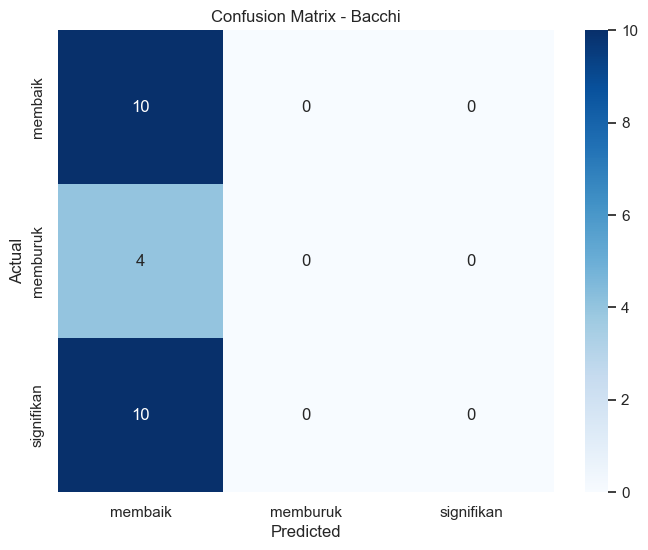

In [16]:
# Convert target labels to one-hot encoding for multiclass classification
num_classes = len(np.unique(y_delta_3))
y_one_hot = np.array(pd.get_dummies(y_delta_3))

# Initialize lists to store the metrics across folds
auc_scores = []
specificity_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []
f1_scores = []

fpr_all = []
tpr_all = []
auc_all = []

model, model_checkpoint_callback = define_model(3, '3_classes/ct/')
model.fit([x], y_one_hot, validation_data=([x], y_one_hot),
        epochs=50, callbacks=[model_checkpoint_callback])

# load the best model
model.load_weights(drive_path + 'Models/bacchi/dataval/3_classes/ct/')

# Evaluate the model on the test set
y_pred = model.predict([x_val])
y_pred_class = np.argmax(y_pred, axis=1)
y_true_class = np.argmax(np.array(y_delta_3_val), axis=1)

# Append scores to lists
auc_scores.append(roc_auc_score(y_true_class, y_pred, multi_class="ovr", average="macro"))
specificity_scores.append(specificity_score(y_true_class, y_pred_class, average="macro"))

class_report = classification_report(y_true_class, y_pred_class, output_dict=True)
recall_scores.append(class_report['macro avg']['recall'])
precision_scores.append(class_report['macro avg']['precision'])
f1_scores.append(class_report['macro avg']['f1-score'])
accuracy_scores.append(class_report['accuracy'])

fpr = dict()
tpr = dict()
y_test_binarizer = label_binarize(y_true_class, classes=[x for x in range(0, num_classes)])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarizer[:,1], y_pred[:,1])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes

fpr_all.append(all_fpr)
tpr_all.append(mean_tpr)

# Calculate metrics for this fold
print(class_report)
print(confusion_matrix(y_true_class, y_pred_class))
print(classification_report(y_true_class, y_pred_class))
print(f'Accuracy : {sum(accuracy_scores)/len(accuracy_scores)}')
print(f'F1 : {sum(f1_scores)/len(f1_scores)}')
print(f'Precision : {sum(precision_scores)/len(precision_scores)}')
print(f'Recall : {sum(recall_scores)/len(recall_scores)}')
print(f'Specificity : {sum(specificity_scores)/len(specificity_scores)}')
print(f'AUC : {sum(auc_scores)/len(auc_scores)}')
print(f'FPR : {fpr_all[0].tolist()}')
print(f'TPR : {tpr_all[0].tolist()}')
# Print heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true_class, y_pred_class), annot=True, cmap='Blues', fmt='g', xticklabels=categorize_3, yticklabels=categorize_3)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {"Bacchi"}')
plt.show()
print()

#### 2 classes

Epoch 1/50
4/4 [==============================] - 185s 34s/step - loss: 0.8879 - accuracy: 0.3306 - f1_m: 0.3104 - precision_m: 0.3209 - recall_m: 0.3031 - val_loss: 7.3204 - val_accuracy: 0.2479 - val_f1_m: 0.2475 - val_precision_m: 0.2475 - val_recall_m: 0.2475
Epoch 2/50
4/4 [==============================] - 175s 30s/step - loss: 0.7445 - accuracy: 0.5041 - f1_m: 0.4962 - precision_m: 0.4963 - recall_m: 0.4963 - val_loss: 17.0794 - val_accuracy: 0.2479 - val_f1_m: 0.2475 - val_precision_m: 0.2475 - val_recall_m: 0.2475
Epoch 3/50
4/4 [==============================] - 148s 32s/step - loss: 0.7019 - accuracy: 0.5289 - f1_m: 0.5306 - precision_m: 0.5306 - recall_m: 0.5306 - val_loss: 38.9764 - val_accuracy: 0.2479 - val_f1_m: 0.2475 - val_precision_m: 0.2475 - val_recall_m: 0.2475
Epoch 4/50
4/4 [==============================] - 124s 32s/step - loss: 0.6834 - accuracy: 0.6116 - f1_m: 0.6066 - precision_m: 0.6066 - recall_m: 0.6066 - val_loss: 74.1324 - val_accuracy: 0.2479 - val_f1_

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

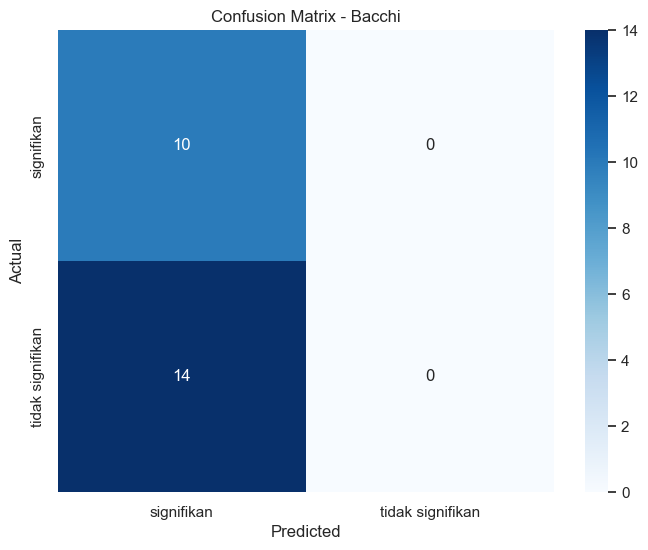

In [17]:
# # Convert target labels to one-hot encoding for multiclass classification
num_classes = len(np.unique(y_delta_2))
y_one_hot = np.array(pd.get_dummies(y_delta_2))

# # Initialize lists to store the metrics across folds
auc_scores, _auc_scores = [], []
accuracy_scores = []
precision_scores, _precision_scores = [], []
recall_scores, _recall_scores = [], []
specificity_scores, _specificity_scores = [], []
f1_scores, _f1_scores = [], []

fpr_all = []
tpr_all = []
auc_all = []

model, model_checkpoint_callback = define_model(2, '2_classes/ct/')
model.fit([x], y_one_hot, validation_data=([x], y_one_hot),
        epochs=50, callbacks=[model_checkpoint_callback])

# load the best model
model.load_weights(drive_path + 'Models/bacchi/dataval/2_classes/ct/')

# Evaluate the model on the test set
y_pred = model.predict([x_val])
y_pred_class = np.argmax(y_pred, axis=1)
y_true_class = np.argmax(np.array(y_delta_2_val), axis=1)

# Append scores to lists
_auc_scores.append(roc_auc_score(y_true_class, y_pred[:,1]))
_specificity_scores.append(specificity_score(y_true_class, y_pred_class))
auc_scores.append(roc_auc_score(y_true_class, y_pred[:,1], multi_class="ovr", average="macro"))
specificity_scores.append(specificity_score(y_true_class, y_pred_class, average="macro"))

class_report = classification_report(y_true_class, y_pred_class, output_dict=True)
recall_scores.append(class_report['macro avg']['recall'])
precision_scores.append(class_report['macro avg']['precision'])
f1_scores.append(class_report['macro avg']['f1-score'])
accuracy_scores.append(class_report['accuracy'])

_recall_scores.append(class_report['0']['recall'])
_precision_scores.append(class_report['0']['precision'])
_f1_scores.append(class_report['0']['f1-score'])

y_test_binarizer = label_binarize(y_true_class, classes=[x for x in range(0, num_classes)])
fpr, tpr, _ = roc_curve(y_test_binarizer, y_pred[:, 1])

fpr_all.append(fpr)
tpr_all.append(tpr)

# Calculate metrics for this fold
print(class_report)
print(confusion_matrix(y_true_class, y_pred_class))
print(classification_report(y_true_class, y_pred_class))
print(f'Accuracy : {sum(accuracy_scores)/len(accuracy_scores)}')
print(f'F1 : {sum(f1_scores)/len(f1_scores)} || {sum(_f1_scores)/len(f1_scores)}')
print(f'Precision : {sum(precision_scores)/len(precision_scores)} || {sum(_precision_scores)/len(precision_scores)}')
print(f'Recall : {sum(recall_scores)/len(recall_scores)} || {sum(_precision_scores)/len(precision_scores)}')
print(f'Specificity : {sum(specificity_scores)/len(specificity_scores)} || {sum(_specificity_scores)/len(specificity_scores)}')
print(f'AUC : {sum(auc_scores)/len(auc_scores)} || {sum(_auc_scores)/len(auc_scores)}')
print(f'FPR : {fpr_all[0].tolist()}')
print(f'TPR : {tpr_all[0].tolist()}')
print(f'TN, FP, FN, TP : {confusion_matrix(y_true_class, y_pred_class).ravel()}')
# Print heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true_class, y_pred_class), annot=True, cmap='Blues', fmt='g', xticklabels=categorize_2, yticklabels=categorize_2)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {"Bacchi"}')
plt.show()
print()

### CT + Clinic

#### 3 classes

Epoch 1/50
4/4 [==============================] - 181s 35s/step - loss: 1.0946 - accuracy: 0.3471 - f1_m: 0.0147 - precision_m: 0.1250 - recall_m: 0.0078 - val_loss: 2.0076 - val_accuracy: 0.2479 - val_f1_m: 0.2475 - val_precision_m: 0.2475 - val_recall_m: 0.2475
Epoch 2/50
4/4 [==============================] - 112s 28s/step - loss: 1.0623 - accuracy: 0.5289 - f1_m: 0.0446 - precision_m: 0.5000 - recall_m: 0.0234 - val_loss: 3.5549 - val_accuracy: 0.2479 - val_f1_m: 0.2475 - val_precision_m: 0.2475 - val_recall_m: 0.2475
Epoch 3/50
4/4 [==============================] - 155s 28s/step - loss: 1.0520 - accuracy: 0.5041 - f1_m: 0.0866 - precision_m: 0.6667 - recall_m: 0.0469 - val_loss: 5.2582 - val_accuracy: 0.3554 - val_f1_m: 0.3534 - val_precision_m: 0.3534 - val_recall_m: 0.3534
Epoch 4/50
4/4 [==============================] - 111s 28s/step - loss: 1.0230 - accuracy: 0.5537 - f1_m: 0.1098 - precision_m: 0.8750 - recall_m: 0.0591 - val_loss: 7.4945 - val_accuracy: 0.3554 - val_f1_m: 

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

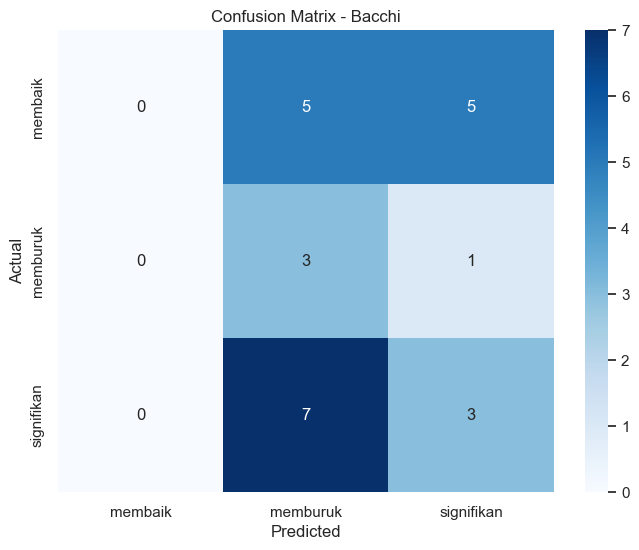

In [18]:
# # Convert target labels to one-hot encoding for multiclass classification
num_classes = len(np.unique(y_delta_3))
y_one_hot = np.array(pd.get_dummies(y_delta_3))

# # Initialize lists to store the metrics across folds
auc_scores = []
specificity_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []
f1_scores = []

fpr_all = []
tpr_all = []
auc_all = []

model, model_checkpoint_callback = define_model(3,'3_classes/ct_clin/', 'ct_clinic')
model.fit([x, x_clin], y_one_hot, validation_data=([x, x_clin], y_one_hot),
        epochs=50, callbacks=[model_checkpoint_callback])

# load the best model
model.load_weights(drive_path + 'Models/bacchi/dataval/3_classes/ct_clin/')

# Evaluate the model on the test set
y_pred = model.predict([x_val, x_clin_val])
y_pred_class = np.argmax(y_pred, axis=1)
y_true_class = np.argmax(np.array(y_delta_3_val), axis=1)

# Append scores to lists
auc_scores.append(roc_auc_score(y_true_class, y_pred, multi_class="ovr", average="macro"))
specificity_scores.append(specificity_score(y_true_class, y_pred_class, average="macro"))

class_report = classification_report(y_true_class, y_pred_class, output_dict=True)
recall_scores.append(class_report['macro avg']['recall'])
precision_scores.append(class_report['macro avg']['precision'])
f1_scores.append(class_report['macro avg']['f1-score'])
accuracy_scores.append(class_report['accuracy'])

fpr = dict()
tpr = dict()
y_test_binarizer = label_binarize(y_true_class, classes=[x for x in range(0, num_classes)])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarizer[:,1], y_pred[:,1])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes

fpr_all.append(all_fpr)
tpr_all.append(mean_tpr)

# Calculate metrics for this fold
print(class_report)
print(confusion_matrix(y_true_class, y_pred_class))
print(classification_report(y_true_class, y_pred_class))
print(f'Accuracy : {sum(accuracy_scores)/len(accuracy_scores)}')
print(f'F1 : {sum(f1_scores)/len(f1_scores)}')
print(f'Precision : {sum(precision_scores)/len(precision_scores)}')
print(f'Recall : {sum(recall_scores)/len(recall_scores)}')
print(f'Specificity : {sum(specificity_scores)/len(specificity_scores)}')
print(f'AUC : {sum(auc_scores)/len(auc_scores)}')
print(f'FPR : {fpr_all[0].tolist()}')
print(f'TPR : {tpr_all[0].tolist()}')
# Print heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true_class, y_pred_class), annot=True, cmap='Blues', fmt='g', xticklabels=categorize_3, yticklabels=categorize_3)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {"Bacchi"}')
plt.show()
print()

#### 2 classes

Epoch 1/50
4/4 [==============================] - 131s 32s/step - loss: 0.9784 - accuracy: 0.2975 - f1_m: 0.2887 - precision_m: 0.2966 - recall_m: 0.2822 - val_loss: 2.9679 - val_accuracy: 0.2479 - val_f1_m: 0.2475 - val_precision_m: 0.2475 - val_recall_m: 0.2475
Epoch 2/50
4/4 [==============================] - 121s 31s/step - loss: 0.7599 - accuracy: 0.4298 - f1_m: 0.4369 - precision_m: 0.4369 - recall_m: 0.4369 - val_loss: 16.3897 - val_accuracy: 0.2479 - val_f1_m: 0.2475 - val_precision_m: 0.2475 - val_recall_m: 0.2475
Epoch 3/50
4/4 [==============================] - 123s 32s/step - loss: 0.6958 - accuracy: 0.5950 - f1_m: 0.5887 - precision_m: 0.5888 - recall_m: 0.5888 - val_loss: 24.2902 - val_accuracy: 0.2479 - val_f1_m: 0.2475 - val_precision_m: 0.2475 - val_recall_m: 0.2475
Epoch 4/50
4/4 [==============================] - 119s 31s/step - loss: 0.6698 - accuracy: 0.7603 - f1_m: 0.7603 - precision_m: 0.7603 - recall_m: 0.7603 - val_loss: 32.2232 - val_accuracy: 0.2479 - val_f1_

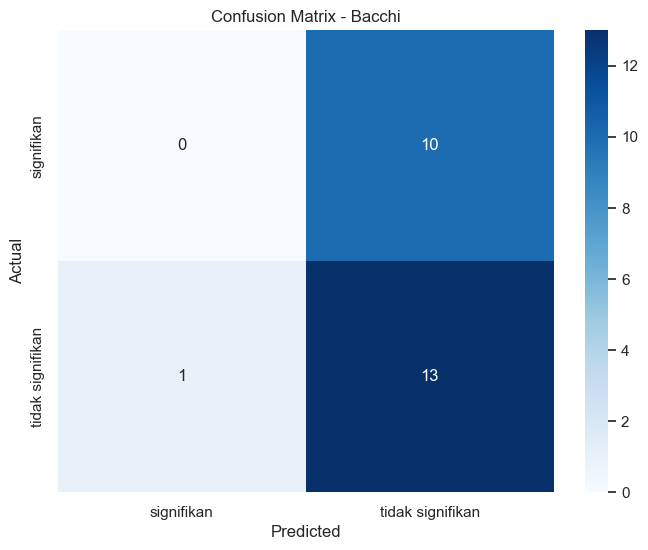

In [19]:
# # Convert target labels to one-hot encoding for multiclass classification
num_classes = len(np.unique(y_delta_2))
y_one_hot = np.array(pd.get_dummies(y_delta_2))

# # Initialize lists to store the metrics across folds
auc_scores, _auc_scores = [], []
accuracy_scores = []
precision_scores, _precision_scores = [], []
recall_scores, _recall_scores = [], []
specificity_scores, _specificity_scores = [], []
f1_scores, _f1_scores = [], []

fpr_all = []
tpr_all = []
auc_all = []

model, model_checkpoint_callback = define_model(2, '2_classes/ct_clin/', 'ct_clinic')
model.fit([x, x_clin], y_one_hot, validation_data=([x, x_clin], y_one_hot),
        epochs=50, callbacks=[model_checkpoint_callback])

# load the best model
model.load_weights(drive_path +  'Models/bacchi/dataval/2_classes/ct_clin/')

# Evaluate the model on the test set
y_pred = model.predict([x_val, x_clin_val])
y_pred_class = np.argmax(y_pred, axis=1)
y_true_class = np.argmax(np.array(y_delta_2_val), axis=1)

# Append scores to lists
_auc_scores.append(roc_auc_score(y_true_class, y_pred[:,1]))
_specificity_scores.append(specificity_score(y_true_class, y_pred_class))
auc_scores.append(roc_auc_score(y_true_class, y_pred[:,1], multi_class="ovr", average="macro"))
specificity_scores.append(specificity_score(y_true_class, y_pred_class, average="macro"))

class_report = classification_report(y_true_class, y_pred_class, output_dict=True)
recall_scores.append(class_report['macro avg']['recall'])
precision_scores.append(class_report['macro avg']['precision'])
f1_scores.append(class_report['macro avg']['f1-score'])
accuracy_scores.append(class_report['accuracy'])

_recall_scores.append(class_report['0']['recall'])
_precision_scores.append(class_report['0']['precision'])
_f1_scores.append(class_report['0']['f1-score'])

y_test_binarizer = label_binarize(y_true_class, classes=[x for x in range(0, num_classes)])
fpr, tpr, _ = roc_curve(y_test_binarizer, y_pred[:, 1])

fpr_all.append(fpr)
tpr_all.append(tpr)

# Calculate metrics for this fold
print(class_report)
print(confusion_matrix(y_true_class, y_pred_class))
print(classification_report(y_true_class, y_pred_class))
print(f'Accuracy : {sum(accuracy_scores)/len(accuracy_scores)}')
print(f'F1 : {sum(f1_scores)/len(f1_scores)} || {sum(_f1_scores)/len(f1_scores)}')
print(f'Precision : {sum(precision_scores)/len(precision_scores)} || {sum(_precision_scores)/len(precision_scores)}')
print(f'Recall : {sum(recall_scores)/len(recall_scores)} || {sum(_precision_scores)/len(precision_scores)}')
print(f'Specificity : {sum(specificity_scores)/len(specificity_scores)} || {sum(_specificity_scores)/len(specificity_scores)}')
print(f'AUC : {sum(auc_scores)/len(auc_scores)} || {sum(_auc_scores)/len(auc_scores)}')
print(f'FPR : {fpr_all[0].tolist()}')
print(f'TPR : {tpr_all[0].tolist()}')
print(f'TN, FP, FN, TP : {confusion_matrix(y_true_class, y_pred_class).ravel()}')
# Print heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true_class, y_pred_class), annot=True, cmap='Blues', fmt='g', xticklabels=categorize_2, yticklabels=categorize_2)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {"Bacchi"}')
plt.show()
print()

### CT + Clinic + Lab

#### 3 Classes

Epoch 1/50
4/4 [==============================] - 125s 31s/step - loss: 1.1248 - accuracy: 0.3967 - f1_m: 0.0454 - precision_m: 0.2083 - recall_m: 0.0256 - val_loss: 1.3766 - val_accuracy: 0.3967 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/50
4/4 [==============================] - 113s 29s/step - loss: 1.0630 - accuracy: 0.3967 - f1_m: 0.1462 - precision_m: 0.4917 - recall_m: 0.0859 - val_loss: 2.0839 - val_accuracy: 0.3967 - val_f1_m: 0.4009 - val_precision_m: 0.4028 - val_recall_m: 0.3991
Epoch 3/50
4/4 [==============================] - 113s 29s/step - loss: 1.0710 - accuracy: 0.3967 - f1_m: 0.1253 - precision_m: 0.3393 - recall_m: 0.0769 - val_loss: 4.3452 - val_accuracy: 0.3967 - val_f1_m: 0.3991 - val_precision_m: 0.3991 - val_recall_m: 0.3991
Epoch 4/50
4/4 [==============================] - 113s 29s/step - loss: 1.0790 - accuracy: 0.4050 - f1_m: 0.0344 - precision_m: 0.5000 - recall_m: 0.0178 - val_loss: 9.2006 - val_accuracy: 0.3967 

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

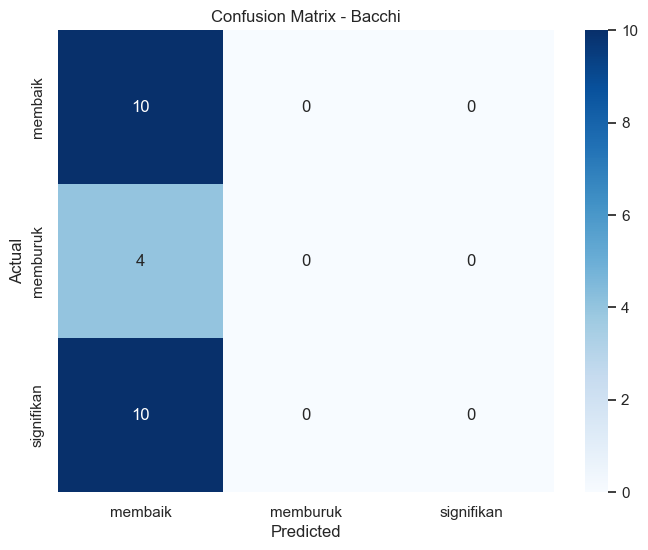

In [20]:
# # Convert target labels to one-hot encoding for multiclass classification
num_classes = len(np.unique(y_delta_3))
y_one_hot = np.array(pd.get_dummies(y_delta_3))

# # Initialize lists to store the metrics across folds
auc_scores = []
specificity_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []
f1_scores = []

fpr_all = []
tpr_all = []
auc_all = []

model, model_checkpoint_callback = define_model(3, '3_classes/ct_clin_lab/', 'ct_clinic_lab')
model.fit([x, x_clin_lab], y_one_hot, validation_data=([x, x_clin_lab], y_one_hot),
        epochs=50, callbacks=[model_checkpoint_callback])

# load the best model
model.load_weights(drive_path + 'Models/bacchi/dataval/3_classes/ct_clin_lab/')

# Evaluate the model on the test set
y_pred = model.predict([x_val, x_clin_lab_val])
y_pred_class = np.argmax(y_pred, axis=1)
y_true_class = np.argmax(np.array(y_delta_3_val), axis=1)

# Append scores to lists
auc_scores.append(roc_auc_score(y_true_class, y_pred, multi_class="ovr", average="macro"))
specificity_scores.append(specificity_score(y_true_class, y_pred_class, average="macro"))

class_report = classification_report(y_true_class, y_pred_class, output_dict=True)
recall_scores.append(class_report['macro avg']['recall'])
precision_scores.append(class_report['macro avg']['precision'])
f1_scores.append(class_report['macro avg']['f1-score'])
accuracy_scores.append(class_report['accuracy'])

fpr = dict()
tpr = dict()
y_test_binarizer = label_binarize(y_true_class, classes=[x for x in range(0, num_classes)])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarizer[:,1], y_pred[:,1])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes

fpr_all.append(all_fpr)
tpr_all.append(mean_tpr)

# Calculate metrics for this fold
print(class_report)
print(confusion_matrix(y_true_class, y_pred_class))
print(classification_report(y_true_class, y_pred_class))
print(f'Accuracy : {sum(accuracy_scores)/len(accuracy_scores)}')
print(f'F1 : {sum(f1_scores)/len(f1_scores)}')
print(f'Precision : {sum(precision_scores)/len(precision_scores)}')
print(f'Recall : {sum(recall_scores)/len(recall_scores)}')
print(f'Specificity : {sum(specificity_scores)/len(specificity_scores)}')
print(f'AUC : {sum(auc_scores)/len(auc_scores)}')
print(f'FPR : {fpr_all[0].tolist()}')
print(f'TPR : {tpr_all[0].tolist()}')
# Print heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true_class, y_pred_class), annot=True, cmap='Blues', fmt='g', xticklabels=categorize_3, yticklabels=categorize_3)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {"Bacchi"}')
plt.show()
print()

#### 2 Classes

Epoch 1/50
4/4 [==============================] - 125s 31s/step - loss: 0.7468 - accuracy: 0.3802 - f1_m: 0.3911 - precision_m: 0.4030 - recall_m: 0.3822 - val_loss: 1.0609 - val_accuracy: 0.2479 - val_f1_m: 0.2475 - val_precision_m: 0.2475 - val_recall_m: 0.2475
Epoch 2/50
4/4 [==============================] - 118s 30s/step - loss: 0.6987 - accuracy: 0.5289 - f1_m: 0.5350 - precision_m: 0.5350 - recall_m: 0.5350 - val_loss: 0.9929 - val_accuracy: 0.2479 - val_f1_m: 0.2475 - val_precision_m: 0.2475 - val_recall_m: 0.2475
Epoch 3/50
4/4 [==============================] - 122s 32s/step - loss: 0.6857 - accuracy: 0.6198 - f1_m: 0.6187 - precision_m: 0.6187 - recall_m: 0.6187 - val_loss: 1.0015 - val_accuracy: 0.2479 - val_f1_m: 0.2475 - val_precision_m: 0.2475 - val_recall_m: 0.2475
Epoch 4/50
4/4 [==============================] - 120s 30s/step - loss: 0.6827 - accuracy: 0.6777 - f1_m: 0.6822 - precision_m: 0.6822 - recall_m: 0.6822 - val_loss: 1.0522 - val_accuracy: 0.2479 - val_f1_m: 

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

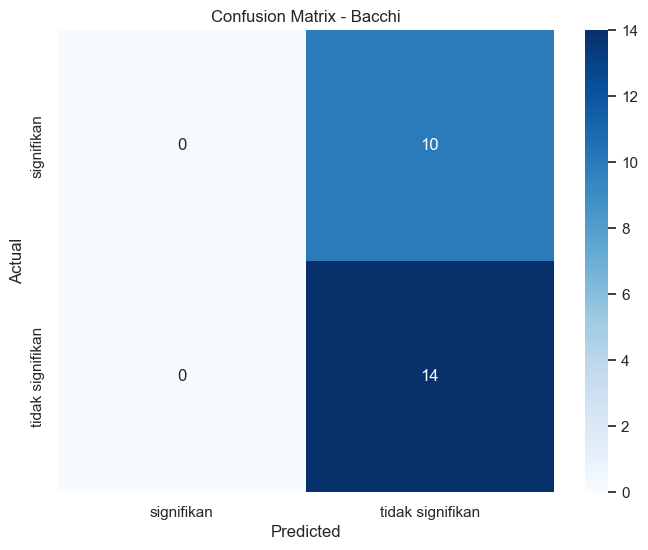

In [21]:
# # Convert target labels to one-hot encoding for multiclass classification
num_classes = len(np.unique(y_delta_2))
y_one_hot = np.array(pd.get_dummies(y_delta_2))

# # Initialize lists to store the metrics across folds
auc_scores, _auc_scores = [], []
accuracy_scores = []
precision_scores, _precision_scores = [], []
recall_scores, _recall_scores = [], []
specificity_scores, _specificity_scores = [], []
f1_scores, _f1_scores = [], []

fpr_all = []
tpr_all = []
auc_all = []

model, model_checkpoint_callback = define_model(2, '2_classes/ct_clin_lab/', 'ct_clinic_lab')
model.fit([x, x_clin_lab], y_one_hot, validation_data=([x, x_clin_lab], y_one_hot),
        epochs=50, callbacks=[model_checkpoint_callback])

# load the best model
model.load_weights(drive_path + 'Models/bacchi/dataval/2_classes/ct_clin_lab/')

# Evaluate the model on the test set
y_pred = model.predict([x_val, x_clin_lab_val])
y_pred_class = np.argmax(y_pred, axis=1)
y_true_class = np.argmax(np.array(y_delta_2_val), axis=1)

# Append scores to lists
_auc_scores.append(roc_auc_score(y_true_class, y_pred[:,1]))
_specificity_scores.append(specificity_score(y_true_class, y_pred_class))
auc_scores.append(roc_auc_score(y_true_class, y_pred[:,1], multi_class="ovr", average="macro"))
specificity_scores.append(specificity_score(y_true_class, y_pred_class, average="macro"))

class_report = classification_report(y_true_class, y_pred_class, output_dict=True)
recall_scores.append(class_report['macro avg']['recall'])
precision_scores.append(class_report['macro avg']['precision'])
f1_scores.append(class_report['macro avg']['f1-score'])
accuracy_scores.append(class_report['accuracy'])

_recall_scores.append(class_report['0']['recall'])
_precision_scores.append(class_report['0']['precision'])
_f1_scores.append(class_report['0']['f1-score'])

y_test_binarizer = label_binarize(y_true_class, classes=[x for x in range(0, num_classes)])
fpr, tpr, _ = roc_curve(y_test_binarizer, y_pred[:, 1])

fpr_all.append(fpr)
tpr_all.append(tpr)

# Calculate metrics for this fold
print(class_report)
print(confusion_matrix(y_true_class, y_pred_class))
print(classification_report(y_true_class, y_pred_class))
print(f'Accuracy : {sum(accuracy_scores)/len(accuracy_scores)}')
print(f'F1 : {sum(f1_scores)/len(f1_scores)} || {sum(_f1_scores)/len(f1_scores)}')
print(f'Precision : {sum(precision_scores)/len(precision_scores)} || {sum(_precision_scores)/len(precision_scores)}')
print(f'Recall : {sum(recall_scores)/len(recall_scores)} || {sum(_precision_scores)/len(precision_scores)}')
print(f'Specificity : {sum(specificity_scores)/len(specificity_scores)} || {sum(_specificity_scores)/len(specificity_scores)}')
print(f'AUC : {sum(auc_scores)/len(auc_scores)} || {sum(_auc_scores)/len(auc_scores)}')
print(f'FPR : {fpr_all[0].tolist()}')
print(f'TPR : {tpr_all[0].tolist()}')
print(f'TN, FP, FN, TP : {confusion_matrix(y_true_class, y_pred_class).ravel()}')
# Print heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true_class, y_pred_class), annot=True, cmap='Blues', fmt='g', xticklabels=categorize_2, yticklabels=categorize_2)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {"Bacchi"}')
plt.show()
print()